# Recurrent neural networks for H.P Lovecraft text generation

"The color out of space" is one of my favorite tales from Lovecraft, i will use it(as well as others as the call of cthulhu) to create a recurrent neural network in tensorflow that learns his style and generates new text in his style

This network is based off of Andrej Karpathy's [post on RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) and [implementation in Torch](https://github.com/karpathy/char-rnn) and an example from "Deep Learning Nanodegree" on udacity. Also, some information [here at r2rt](http://r2rt.com/recurrent-neural-networks-in-tensorflow-ii.html) and from [Sherjil Ozair](https://github.com/sherjilozair/char-rnn-tensorflow) on GitHub. 

## General architecture using "Long short term memory" units in the recurrent layers

<img src="assets/charseq.jpeg" width="500">

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import time
from collections import namedtuple

import numpy as np
import tensorflow as tf
from nltk.tokenize import word_tokenize
import nltk
import itertools
import matplotlib.pyplot as plt
from time import gmtime, strftime ,localtime
import shutil
import os.path

In [3]:
# Run only the  first time nltk is used to download language
#nltk.download()

### Define conf variables and hyper parameteters 

mode = "characters" #characters or words

epochs = 3
batch_size = 64       # Sequences per batch
num_steps = 400         # Number of sequence steps per batch
lstm_size = 2048         # Size of hidden layers in LSTMs
num_layers = 2          # Number of LSTM layers
learning_rate = 0.000075 # Learning rate
keep_prob = 1# Dropout keep probability
negative_sampled = 100 #in words mode ,how many negative words to sample to improve trainint time

resume_from_checkpoint = True
delete_checkpoints  = False


In [4]:
mode = "characters" #characters or words

epochs = 50
batch_size = 128       # Sequences per batch
num_steps = 50         # Number of sequence steps per batch
lstm_size = 3000         # Size of hidden layers in LSTMs
num_layers = 2          # Number of LSTM layers
learning_rate = 0.0001 # Learning rate
keep_prob = 1# Dropout keep probability
negative_sampled = 4300 #in words mode ,how many negative words to sample to improve trainint time

resume_from_checkpoint = False
delete_checkpoints  = True

In [5]:
if not resume_from_checkpoint and delete_checkpoints and os.path.exists("./checkpoints/"):
    shutil.rmtree("./checkpoints/")

### Define base text
Once trained ,the network can take base text and a sequence size and generate new text using base text as first characters in the sequence. For every element in base text wi will create a list that will store generated text as training goes, to be able to compare results between steps

In [6]:
text_to_try = ["In the first place","the night before","horror","creature","night","dream","thing","That night","mountain","Ammi","Cthulhu","raven","bird","nevermore","dead","The bird"]

#### Function that separates text into tokens(for whitespace characters, only new line is implemented, missing tabs and others=

In [7]:
def tokenize_by_words(text):
    text = text.replace("\n"," new_line_token ")
    tokens = []
    splitted =[[word_tokenize(w),' ']for w in text.split()]
    splitted = list(itertools.chain(*list(itertools.chain(*splitted))))
    
    token_list = []
    i = 0
    while i < len(splitted):
        if splitted[i] == "new_line_token":
            if   token_list[-1]==" ":
                token_list[-1] = splitted[i]
            else:
                token_list.append(splitted[i])
            i+=1
        else:
            token_list.append(splitted[i])
        i+=1
    
    return token_list

def tokenize_by_characters(text):
    return list(text)

def tokenize_text(text,mode="characters"):
    if mode == "characters":
        return tokenize_by_characters(text)
    elif mode == "words":
        return tokenize_by_words(text)
    
tokenize_text("Hello, my name is Luis Leal!\n\nFrom Guatemala",mode)
#tokenize_text("Hello, my name is Luis Leal!\n\nFrom Guatemala","words")


['H',
 'e',
 'l',
 'l',
 'o',
 ',',
 ' ',
 'm',
 'y',
 ' ',
 'n',
 'a',
 'm',
 'e',
 ' ',
 'i',
 's',
 ' ',
 'L',
 'u',
 'i',
 's',
 ' ',
 'L',
 'e',
 'a',
 'l',
 '!',
 '\n',
 '\n',
 'F',
 'r',
 'o',
 'm',
 ' ',
 'G',
 'u',
 'a',
 't',
 'e',
 'm',
 'a',
 'l',
 'a']

First we'll load the text file and convert it into integers for our network to use. Here I'm creating a couple dictionaries to convert the characters to and from integers. Encoding the characters as integers makes it easier to use as input in the network.

In [8]:
with open('corpus.txt', 'r') as f:
    text=f.read()

In [9]:
vocab = set(tokenize_text(text,mode))
vocab_to_int = {c: i for i, c in enumerate(vocab)}
int_to_vocab = dict(enumerate(vocab))
n_vocab = len(vocab)

### Get a little portion of text for validation

In [10]:
tokenized_text = tokenize_text(text,mode)
encoded_dataset = np.array([vocab_to_int[c] for c in tokenized_text if c in vocab_to_int], dtype=np.int32)

In [11]:
validation_size = batch_size * num_steps #create a single baty
validation_start_index = len(encoded_dataset) - validation_size

encoded = encoded_dataset[:validation_start_index]
encoded_val = encoded_dataset[validation_start_index:]

In [12]:
def encoded_to_text(encoded):
    return "".join([int_to_vocab[number] for number in encoded])

print(encoded_to_text(encoded_val[0:100]))

ill; and we to sit there in an utter dumb happiness, until they that did attend me, were come again.


In [13]:
val_text =encoded_to_text(encoded_val)
text = encoded_to_text(encoded)

Let's check out the first 100 characters of train and validation, make sure everything is peachy.  line of a book ever.

In [14]:
text[:100]

'THE COLOUR OUT OF SPACE\n\nWest of Arkham the hills rise wild, and there are valleys with deep woods t'

In [15]:
val_text[:100]

'ill; and we to sit there in an utter dumb happiness, until they that did attend me, were come again.'

And we can see the characters encoded as integersin both train and validation

In [16]:
encoded[:100]

array([ 92,  61,  18, 100, 110,   5,  55,   5,  62,  51, 100,   5,  62,
        92, 100,   5,   9, 100,  14,  87,  68, 110,  18,  72,  72,  38,
        54, 117,   7, 100,  76,  60, 100,  68,  89,  98,  39, 101,  19,
       100,   7,  39,  54, 100,  39,  22,  96,  96, 117, 100,  89,  22,
       117,  54, 100,  35,  22,  96,  79,   3, 100, 101,  83,  79, 100,
         7,  39,  54,  89,  54, 100, 101,  89,  54, 100,  28, 101,  96,
        96,  54,  12, 117, 100,  35,  22,   7,  39, 100,  79,  54,  54,
        86, 100,  35,  76,  76,  79, 117, 100,   7], dtype=int32)

In [17]:
encoded_val[0:100]

array([ 22,  96,  96,  44, 100, 101,  83,  79, 100,  35,  54, 100,   7,
        76, 100, 117,  22,   7, 100,   7,  39,  54,  89,  54, 100,  22,
        83, 100, 101,  83, 100, 114,   7,   7,  54,  89, 100,  79, 114,
        19,  94, 100,  39, 101,  86,  86,  22,  83,  54, 117, 117,   3,
       100, 114,  83,   7,  22,  96, 100,   7,  39,  54,  12, 100,   7,
        39, 101,   7, 100,  79,  22,  79, 100, 101,   7,   7,  54,  83,
        79, 100,  19,  54,   3, 100,  35,  54,  89,  54, 100,  97,  76,
        19,  54, 100, 101,  41, 101,  22,  83,  24], dtype=int32)

Since the network is working with individual english tokens, it's similar to a classification problem in which we are trying to predict the next character from the previous text.  Here's how many 'classes' our network has to pick from.

In [18]:
len(vocab)

123

## Making training mini-batches

Here is where we'll make our mini-batches for training. Remember that we want our batches to be multiple sequences of some desired number of sequence steps. Considering a simple example, our batches would look like this:

<img src="assets/sequence_batching@1x.png" width=500px>


<br>
We have our text encoded as integers as one long array in `encoded`. Let's create a function that will give us an iterator for our batches. I like using [generator functions](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/) to do this. Then we can pass `encoded` into this function and get our batch generator.

The first thing we need to do is discard some of the text so we only have completely full batches. Each batch contains $N \times M$ characters, where $N$ is the batch size (the number of sequences) and $M$ is the number of steps. Then, to get the number of batches we can make from some array `arr`, you divide the length of `arr` by the batch size. Once you know the number of batches and the batch size, you can get the total number of characters to keep.

After that, we need to split `arr` into $N$ sequences. You can do this using `arr.reshape(size)` where `size` is a tuple containing the dimensions sizes of the reshaped array. We know we want $N$ sequences (`n_seqs` below), let's make that the size of the first dimension. For the second dimension, you can use `-1` as a placeholder in the size, it'll fill up the array with the appropriate data for you. After this, you should have an array that is $N \times (M * K)$ where $K$ is the number of batches.

Now that we have this array, we can iterate through it to get our batches. The idea is each batch is a $N \times M$ window on the array. For each subsequent batch, the window moves over by `n_steps`. We also want to create both the input and target arrays. Remember that the targets are the inputs shifted over one character. You'll usually see the first input character used as the last target character, so something like this:
```python
y[:, :-1], y[:, -1] = x[:, 1:], x[:, 0]
```
where `x` is the input batch and `y` is the target batch.

The way I like to do this window is use `range` to take steps of size `n_steps` from $0$ to `arr.shape[1]`, the total number of steps in each sequence. That way, the integers you get from `range` always point to the start of a batch, and each window is `n_steps` wide.

In [19]:
def get_batches(arr, n_seqs, n_steps):
    '''Create a generator that returns batches of size
       n_seqs x n_steps from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       n_seqs: Batch size, the number of sequences per batch
       n_steps: Number of sequence steps per batch
    '''
    # Get the batch size and number of batches we can make
    batch_size = n_seqs * n_steps 
    n_batches =  len(arr)//batch_size
    
    # Keep only enough characters to make full batches
    arr =  arr[:n_batches*batch_size]
    
    # Reshape into n_seqs rows
    arr = arr.reshape((n_seqs,-1))
    
    for n in range(0, arr.shape[1], n_steps):
        # The features
        x = arr[:,n:n+n_steps]
        # The targets, shifted by one
        y = np.zeros(x.shape)
        y[:,:-1],y[:,-1] = x[:,1:] ,x[:,0]
        yield x, y

Now I'll make my data sets and we can check out what's going on here. Here I'm going to use a batch size of 10 and 50 sequence steps.

In [20]:
batches = get_batches(encoded, 10, 50)
x, y = next(batches)

In [21]:
print('x\n', x[:10, :10])
print('\ny\n', y[:10, :10])

x
 [[ 92  61  18 100 110   5  55   5  62  51]
 [ 79 100  39 101  28  54 100  12  76 114]
 [100 101  83  79 100  86  22   7   7  54]
 [100 117  54  89  28 101  83   7 100  76]
 [ 41  54   7  39  54  89   3 100  35  39]
 [ 54 100  22  19  86  89  54 117 117  22]
 [ 39  22  83  41 100  76  97  97 114  89]
 [ 96 101  12 100   7  76  35 101  89  79]
 [ 86  35 101  89  79 100 101  83  79 100]
 [100   7  39  22  83  41 100  35 101 117]]

y
 [[ 61.  18. 100. 110.   5.  55.   5.  62.  51. 100.]
 [100.  39. 101.  28.  54. 100.  12.  76. 114. 100.]
 [101.  83.  79. 100.  86.  22.   7.   7.  54.  79.]
 [117.  54.  89.  28. 101.  83.   7. 100.  76.  60.]
 [ 54.   7.  39.  54.  89.   3. 100.  35.  39.  22.]
 [100.  22.  19.  86.  89.  54. 117. 117.  22.  76.]
 [ 22.  83.  41. 100.  76.  97.  97. 114.  89.  89.]
 [101.  12. 100.   7.  76.  35. 101.  89.  79. 100.]
 [ 35. 101.  89.  79. 100. 101.  83.  79. 100.  79.]
 [  7.  39.  22.  83.  41. 100.  35. 101. 117.   3.]]


## Building the model

Below is where you'll build the network. We'll break it up into parts so it's easier to reason about each bit. Then we can connect them up into the whole network.

<img src="assets/charRNN.png" width=500px>


### Inputs

First off we'll create our input placeholders. As usual we need placeholders for the training data and the targets. We'll also create a placeholder for dropout layers called `keep_prob`. This will be a scalar, that is a 0-D tensor. To make a scalar, you create a placeholder without giving it a size.

In [22]:
def build_inputs(batch_size, num_steps):
    ''' Define placeholders for inputs, targets, and dropout 
    
        Arguments
        ---------
        batch_size: Batch size, number of sequences per batch
        num_steps: Number of sequence steps in a batch
        
    '''
    # Declare placeholders we'll feed into the graph
    inputs = tf.placeholder(tf.int32,[batch_size,num_steps],name="inputs")
    targets = tf.placeholder(tf.int32,[batch_size,num_steps],name="targets")
    
    # Keep probability placeholder for drop out layers
    keep_prob = tf.placeholder(tf.float32,name="keep_prob")
    
    return inputs, targets, keep_prob

### LSTM Cell

Here we will create the LSTM cell we'll use in the hidden layer. We'll use this cell as a building block for the RNN. So we aren't actually defining the RNN here, just the type of cell we'll use in the hidden layer.

We first create a basic LSTM cell with

```python
lstm = tf.contrib.rnn.BasicLSTMCell(num_units)
```

where `num_units` is the number of units in the hidden layers in the cell. Then we can add dropout by wrapping it with 

```python
tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
```
You pass in a cell and it will automatically add dropout to the inputs or outputs. Finally, we can stack up the LSTM cells into layers with [`tf.contrib.rnn.MultiRNNCell`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/rnn/MultiRNNCell). With this, you pass in a list of cells and it will send the output of one cell into the next cell. For example,

```python
tf.contrib.rnn.MultiRNNCell([cell]*num_layers)
```

This might look a little weird if you know Python well because this will create a list of the same `cell` object. However, TensorFlow will create different weight matrices for all `cell` objects. Even though this is actually multiple LSTM cells stacked on each other, you can treat the multiple layers as one cell.

We also need to create an initial cell state of all zeros. This can be done like so

```python
initial_state = cell.zero_state(batch_size, tf.float32)
```


In [23]:
def build_lstm(lstm_size, num_layers, batch_size, keep_prob):
    ''' Build LSTM cell.
    
        Arguments
        ---------
        keep_prob: Scalar tensor (tf.placeholder) for the dropout keep probability
        lstm_size: Size of the hidden layers in the LSTM cells
        num_layers: Number of LSTM layers
        batch_size: Batch size

    '''
    ### Build the LSTM Cell
    # Use a basic LSTM cell
    # Add dropout to the cell outputs
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.DropoutWrapper( tf.contrib.rnn.BasicLSTMCell(lstm_size),output_keep_prob = keep_prob) for _ in range(num_layers)])
    initial_state = cell.zero_state(batch_size,tf.float32)
    
    return cell, initial_state

### RNN Output

Here we'll create the output layer. We need to connect the output of the RNN cells to a full connected layer with a softmax output. The softmax output gives us a probability distribution we can use to predict the next character, so we want this layer to have size $C$, the number of classes/characters we have in our text.

If our input has batch size $N$, number of steps $M$, and the hidden layer has $L$ hidden units, then the output is a 3D tensor with size $N \times M \times L$. The output of each LSTM cell has size $L$, we have $M$ of them, one for each sequence step, and we have $N$ sequences. So the total size is $N \times M \times L$. 

We are using the same fully connected layer, the same weights, for each of the outputs. Then, to make things easier, we should reshape the outputs into a 2D tensor with shape $(M * N) \times L$. That is, one row for each sequence and step, where the values of each row are the output from the LSTM cells. We get the LSTM output as a list, `lstm_output`. First we need to concatenate this whole list into one array with [`tf.concat`](https://www.tensorflow.org/api_docs/python/tf/concat). Then, reshape it (with `tf.reshape`) to size $(M * N) \times L$.

One we have the outputs reshaped, we can do the matrix multiplication with the weights. We need to wrap the weight and bias variables in a variable scope with `tf.variable_scope(scope_name)` because there are weights being created in the LSTM cells. TensorFlow will throw an error if the weights created here have the same names as the weights created in the LSTM cells, which they will be default. To avoid this, we wrap the variables in a variable scope so we can give them unique names.


In [24]:
def build_output(lstm_output, in_size, out_size):
    ''' Build a softmax layer, return the softmax output and logits.
    
        Arguments
        ---------
        
        lstm_output: List of output tensors from the LSTM layer
        in_size: Size of the input tensor, for example, size of the LSTM cells
        out_size: Size of this softmax layer
    
    '''
    print(lstm_output)
    # Reshape output so it's a bunch of rows, one row for each step for each sequence.
    # Concatenate lstm_output over axis 1 (the columns)
    seq_output = tf.concat(lstm_output,axis=1)
    # Reshape seq_output to a 2D tensor with lstm_size columns
    x = tf.reshape(seq_output,[-1,in_size])
    # Connect the RNN outputs to a softmax layer
    with tf.variable_scope('softmax'):
        # Create the weight and bias variables here
        softmax_w = tf.Variable(tf.truncated_normal((in_size, out_size),stddev=0.1))
        softmax_b = tf.Variable(tf.zeros([out_size]))
    
    # Since output is a bunch of rows of RNN cell outputs, logits will be a bunch
    # of rows of logit outputs, one for each step and sequence
    logits =  tf.add(tf.matmul(x,softmax_w),softmax_b) 
    
    # Use softmax to get the probabilities for predicted characters
    out = tf.nn.softmax(logits,name ="out")
    
    return out, logits,softmax_w,softmax_b,x

### Training loss

Next up is the training loss. We get the logits and targets and calculate the softmax cross-entropy loss. First we need to one-hot encode the targets, we're getting them as encoded characters. Then, reshape the one-hot targets so it's a 2D tensor with size $(M*N) \times C$ where $C$ is the number of classes/characters we have. Remember that we reshaped the LSTM outputs and ran them through a fully connected layer with $C$ units. So our logits will also have size $(M*N) \times C$.

Then we run the logits and targets through `tf.nn.softmax_cross_entropy_with_logits` and find the mean to get the loss.

In [25]:
def build_loss(lstm_output,logits, targets, lstm_size, num_classes,softmax_w,softmax_b):
    ''' Calculate the loss from the logits and the targets.
    
        Arguments
        ---------
        logits: Logits from final fully connected layer
        targets: Targets for supervised learning
        lstm_size: Number of LSTM hidden units
        num_classes: Number of classes in targets
        
    '''
    # One-hot encode targets and reshape to match logits, one row per sequence per step
    y_one_hot = tf.one_hot(targets,num_classes)
    y_reshaped =  tf.reshape(y_one_hot,logits.get_shape())
    
    
    # Softmax cross entropy loss
    if mode == "characters":
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y_reshaped))
    elif mode == "words":
        loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(tf.transpose(softmax_w),softmax_b,tf.reshape(tf.argmax( y_reshaped,axis = 1),shape=(y_reshaped.get_shape()[0],1)),tf.concat(lstm_output,axis=1),negative_sampled,len(vocab)))
    
    return loss

### Optimizer

Here we build the optimizer. Normal RNNs have have issues gradients exploding and disappearing. LSTMs fix the disappearance problem, but the gradients can still grow without bound. To fix this, we can clip the gradients above some threshold. That is, if a gradient is larger than that threshold, we set it to the threshold. This will ensure the gradients never grow overly large. Then we use an AdamOptimizer for the learning step.

In [26]:
def build_optimizer(loss, learning_rate, grad_clip,global_step):
    ''' Build optmizer for training, using gradient clipping.
    
        Arguments:
        loss: Network loss
        learning_rate: Learning rate for optimizer
        global_step: to control the total number of train steps
    
    '''
    
    # Optimizer for training, using gradient clipping to control exploding gradients
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), grad_clip)
    train_op = tf.train.AdamOptimizer(learning_rate)
    optimizer = train_op.apply_gradients(zip(grads, tvars),global_step)
    
    return optimizer

### Build the network

Now we can put all the pieces together and build a class for the network. To actually run data through the LSTM cells, we will use [`tf.nn.dynamic_rnn`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/nn/dynamic_rnn). This function will pass the hidden and cell states across LSTM cells appropriately for us. It returns the outputs for each LSTM cell at each step for each sequence in the mini-batch. It also gives us the final LSTM state. We want to save this state as `final_state` so we can pass it to the first LSTM cell in the the next mini-batch run. For `tf.nn.dynamic_rnn`, we pass in the cell and initial state we get from `build_lstm`, as well as our input sequences. Also, we need to one-hot encode the inputs before going into the RNN. 


In [27]:
class CharRNN:
    
    def __init__(self, num_classes, batch_size=64, num_steps=50, 
                       lstm_size=128, num_layers=2, learning_rate=0.001, 
                       grad_clip=5, sampling=False,device = "/device:GPU:0"):
    
        # When we're using this network for sampling later, we'll be passing in
        # one character at a time, so providing an option for that
        if sampling == True:
            batch_size, num_steps = 1, 1
        else:
            batch_size, num_steps = batch_size, num_steps

        tf.reset_default_graph()
        
        with tf.device(device):
            self.global_step_tensor = tf.Variable(0,trainable=False,name = "global_step")
            # Build the input placeholder tensors
            self.inputs, self.targets, self.keep_prob = build_inputs(batch_size,num_steps)
            # Build the LSTM cell
            cell, self.initial_state = build_lstm(lstm_size,num_layers,batch_size,self.keep_prob)
            ### Run the data through the RNN layers
            # First, one-hot encode the input tokens
            x_one_hot = tf.one_hot(self.inputs,num_classes)

            self.grad_clip  = grad_clip
            # Run each sequence step through the RNN with tf.nn.dynamic_rnn 
            outputs, state = tf.nn.dynamic_rnn(cell,x_one_hot,initial_state=self.initial_state)
            self.final_state = state

            # Get softmax predictions and logits
            self.prediction, self.logits ,self.softmax_w,self.softmax_b,self.lstm_output_reshaped  = build_output(outputs,lstm_size,num_classes)

            # Loss and optimizer (with gradient clipping)
            self.loss =  build_loss(self.lstm_output_reshaped ,self.logits,self.targets,lstm_size,num_classes,self.softmax_w,self.softmax_b)
            self.optimizer = build_optimizer(self.loss,learning_rate,grad_clip,self.global_step_tensor)

## Hyperparameters

Here are the hyperparameters for the network.

* `batch_size` - Number of sequences running through the network in one pass.
* `num_steps` - Number of characters in the sequence the network is trained on. Larger is better typically, the network will learn more long range dependencies. But it takes longer to train. 100 is typically a good number here.
* `lstm_size` - The number of units in the hidden layers.
* `num_layers` - Number of hidden LSTM layers to use
* `learning_rate` - Learning rate for training
* `keep_prob` - The dropout keep probability when training. If you're network is overfitting, try decreasing this.

Here's some good advice from Andrej Karpathy on training the network:. 

> ## Tips and Tricks

>### Monitoring Validation Loss vs. Training Loss
>If you're somewhat new to Machine Learning or Neural Networks it can take a bit of expertise to get good models. The most important quantity to keep track of is the difference between your training loss (printed during training) and the validation loss (printed once in a while when the RNN is run on the validation data (by default every 1000 iterations)). In particular:

> - If your training loss is much lower than validation loss then this means the network might be **overfitting**. Solutions to this are to decrease your network size, or to increase dropout. For example you could try dropout of 0.5 and so on.
> - If your training/validation loss are about equal then your model is **underfitting**. Increase the size of your model (either number of layers or the raw number of neurons per layer)

> ### Approximate number of parameters

> The two most important parameters that control the model are `lstm_size` and `num_layers`. I would advise that you always use `num_layers` of either 2/3. The `lstm_size` can be adjusted based on how much data you have. The two important quantities to keep track of here are:

> - The number of parameters in your model. This is printed when you start training.
> - The size of your dataset. 1MB file is approximately 1 million characters.

>These two should be about the same order of magnitude. It's a little tricky to tell. Here are some examples:

> - I have a 100MB dataset and I'm using the default parameter settings (which currently print 150K parameters). My data size is significantly larger (100 mil >> 0.15 mil), so I expect to heavily underfit. I am thinking I can comfortably afford to make `lstm_size` larger.
> - I have a 10MB dataset and running a 10 million parameter model. I'm slightly nervous and I'm carefully monitoring my validation loss. If it's larger than my training loss then I may want to try to increase dropout a bit and see if that helps the validation loss.

> ### Best models strategy

>The winning strategy to obtaining very good models (if you have the compute time) is to always err on making the network larger (as large as you're willing to wait for it to compute) and then try different dropout values (between 0,1). Whatever model has the best validation performance (the loss, written in the checkpoint filename, low is good) is the one you should use in the end.

>It is very common in deep learning to run many different models with many different hyperparameter settings, and in the end take whatever checkpoint gave the best validation performance.

>By the way, the size of your training and validation splits are also parameters. Make sure you have a decent amount of data in your validation set or otherwise the validation performance will be noisy and not very informative.

In [28]:
def get_number_of_parameters():
    total_parameters = 0
    for variable in tf.trainable_variables():
        shape = variable.get_shape()
        #print(shape)
        #print(len(shape))
        variable_parameters = 1
        
        for dim in shape:
            #print(dim)
            variable_parameters*=dim.value
        #print(variable_parameters)
        total_parameters+= variable_parameters
    return total_parameters

In [29]:
def pick_top_n(preds, vocab_size, top_n=5):
    p = np.squeeze(preds)
    p[np.argsort(p)[:-top_n]] = 0
    p = p / np.sum(p)
    c = np.random.choice(vocab_size, 1, p=p)[0]
    return c

## Time for training

This is typical training code, passing inputs and targets into the network, then running the optimizer. Here we also get back the final LSTM state for the mini-batch. Then, we pass that state back into the network so the next batch can continue the state from the previous batch. And every so often (set by `save_every_n`) I save a checkpoint.

Here I'm saving checkpoints with the format

`i{iteration number}_l{# hidden layer units}.ckpt`


In [30]:
losses = {"train":[],"validation":[]}
x_steps = list()

In [31]:
#epochs = 1
# Save every N iterations
save_every_n = 50
print_loss_every_n = 15
sample_every = 500
print_epoch_time_every = 1


model = CharRNN(len(vocab), batch_size=batch_size, num_steps=num_steps,
                lstm_size=lstm_size, num_layers=num_layers, 
                learning_rate=learning_rate,device="/device:GPU:0")
    #print("after model")

saver = tf.train.Saver(max_to_keep=5)
print("Training starting at time:",strftime("%Y-%m-%d %H:%M:%S", localtime()))
train_start_time = time.time()
with tf.Session(config=tf.ConfigProto(log_device_placement=True,allow_soft_placement= True)) as sess:
    sess.run(tf.global_variables_initializer())
    print("Number of parameters:",get_number_of_parameters(),"Dataset size:",len(encoded))
    #print("after initializer")
    if resume_from_checkpoint:
        latest_checkpoint = tf.train.latest_checkpoint('checkpoints')
        saver.restore(sess, latest_checkpoint)
    counter = 0
    for e in range(epochs):
        # Train network
        epoch_start = time.time()

        new_state = sess.run(model.initial_state)
        loss = 0
        for x, y in get_batches(encoded, batch_size, num_steps):


            start = time.time()
            feed = {model.inputs: x,
                        model.targets: y,
                        model.keep_prob: keep_prob,
                        model.initial_state: new_state}
            batch_loss, new_state, _ = sess.run([model.loss, 
                                                     model.final_state, 
                                                     model.optimizer], 
                                                     feed_dict=feed)


            end = time.time()
            if counter%print_loss_every_n == 0:
                val_batches = get_batches(encoded_val,int(len(encoded_val)/num_steps),num_steps)
                x_val,y_val = next(val_batches)

                val_dict = {model.inputs: x_val,
                                model.targets: y_val,
                                model.keep_prob: 1,
                                model.initial_state: new_state}

                val_loss,prediction = sess.run([model.loss,model.prediction],feed_dict=val_dict)

                losses["train"].append(batch_loss)
                losses["validation"].append(val_loss)


                global_step = tf.train.global_step(sess,model.global_step_tensor)
                x_steps.append(global_step)

                print('Epoch: {}/{}... '.format(e+1, epochs),
                          'Training Step: {}... '.format(global_step),
                          'Training loss: {:.4f}... '.format(batch_loss),
                          'Val loss: {:.4f}... '.format(val_loss),
                          '{:.4f} sec/batch'.format((end-start)))

            if (counter % save_every_n == 0):
                global_step = tf.train.global_step(sess,model.global_step_tensor)
                saver.save(sess, "checkpoints/m{}_i{}_l{}.ckpt".format(mode,global_step, lstm_size))

            counter += 1
                #learning_rate*=0.75
                #model.optimizer = build_optimizer(model.loss,learning_rate,model.grad_clip,model.global_step_tensor)

        epoch_end = time.time()


        if ((e+1) % print_epoch_time_every== 0):
            print('Epoch {}/{} time:{}...'.format(e+1,epochs,epoch_end-epoch_start),
                     " finished at",strftime("%Y-%m-%d %H:%M:%S", localtime()))


    global_step = tf.train.global_step(sess,model.global_step_tensor)
    saver.save(sess, "checkpoints/m{}_i{}_l{}.ckpt".format(mode,global_step, lstm_size))

print("Training ending at time:",strftime("%Y-%m-%d %H:%M:%S", localtime()))
print("Trainint total time:",time.time()-train_start_time)

Tensor("rnn/transpose_1:0", shape=(128, 50, 3000), dtype=float32, device=/device:GPU:0)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Training starting at time: 2018-10-27 01:13:35
Number of parameters: 109869123 Dataset size: 5942190
Epoch: 1/50...  Training Step: 1...  Training loss: 4.8128...  Val loss: 4.6919...  1.8301 sec/batch
Epoch: 1/50...  Training Step: 16...  Training loss: 3.1104...  Val loss: 3.2184...  1.0889 sec/batch
Epoch: 1/50...  Training Step: 31...  Training loss: 3.0470...  Val loss: 3.0380...  1.0889 sec/batch
Epoch: 1/50...  Training Step: 46...  Training loss: 3.0248...  Val loss: 3.0093...  1.0957 sec/batch
Epoch: 1/50...  Training Step: 61...  Training loss: 2.9829...  Val loss: 2.9903...  1.0894 sec/batch
Epoch: 1/50...  Training Step: 76...  Training loss: 2.9513...  Val loss: 2.9702...  1.0965 sec/batch
Epoch: 1

Epoch: 2/50...  Training Step: 1111...  Training loss: 2.0031...  Val loss: 1.9290...  1.0914 sec/batch
Epoch: 2/50...  Training Step: 1126...  Training loss: 1.9795...  Val loss: 1.9081...  1.0965 sec/batch
Epoch: 2/50...  Training Step: 1141...  Training loss: 1.9995...  Val loss: 1.9142...  1.0925 sec/batch
Epoch: 2/50...  Training Step: 1156...  Training loss: 2.0197...  Val loss: 1.8954...  1.0928 sec/batch
Epoch: 2/50...  Training Step: 1171...  Training loss: 2.0099...  Val loss: 1.9147...  1.0972 sec/batch
Epoch: 2/50...  Training Step: 1186...  Training loss: 1.9759...  Val loss: 1.8993...  1.0983 sec/batch
Epoch: 2/50...  Training Step: 1201...  Training loss: 1.9703...  Val loss: 1.8937...  1.0947 sec/batch
Epoch: 2/50...  Training Step: 1216...  Training loss: 1.9625...  Val loss: 1.8843...  1.0935 sec/batch
Epoch: 2/50...  Training Step: 1231...  Training loss: 1.9804...  Val loss: 1.8870...  1.1120 sec/batch
Epoch: 2/50...  Training Step: 1246...  Training loss: 1.9709...

Epoch: 3/50...  Training Step: 2296...  Training loss: 1.6832...  Val loss: 1.6220...  1.0929 sec/batch
Epoch: 3/50...  Training Step: 2311...  Training loss: 1.6916...  Val loss: 1.6200...  1.0942 sec/batch
Epoch: 3/50...  Training Step: 2326...  Training loss: 1.6999...  Val loss: 1.6116...  1.0948 sec/batch
Epoch: 3/50...  Training Step: 2341...  Training loss: 1.7256...  Val loss: 1.6196...  1.0983 sec/batch
Epoch: 3/50...  Training Step: 2356...  Training loss: 1.7184...  Val loss: 1.6131...  1.0921 sec/batch
Epoch: 3/50...  Training Step: 2371...  Training loss: 1.7239...  Val loss: 1.6135...  1.0926 sec/batch
Epoch: 3/50...  Training Step: 2386...  Training loss: 1.7202...  Val loss: 1.6116...  1.0956 sec/batch
Epoch: 3/50...  Training Step: 2401...  Training loss: 1.7488...  Val loss: 1.6336...  1.1071 sec/batch
Epoch: 3/50...  Training Step: 2416...  Training loss: 1.6843...  Val loss: 1.6041...  1.0952 sec/batch
Epoch: 3/50...  Training Step: 2431...  Training loss: 1.6775...

Epoch: 4/50...  Training Step: 3481...  Training loss: 1.5336...  Val loss: 1.5214...  1.0971 sec/batch
Epoch: 4/50...  Training Step: 3496...  Training loss: 1.5151...  Val loss: 1.5202...  1.0939 sec/batch
Epoch: 4/50...  Training Step: 3511...  Training loss: 1.5253...  Val loss: 1.5081...  1.0916 sec/batch
Epoch: 4/50...  Training Step: 3526...  Training loss: 1.5003...  Val loss: 1.4998...  1.0904 sec/batch
Epoch: 4/50...  Training Step: 3541...  Training loss: 1.4809...  Val loss: 1.5013...  1.0971 sec/batch
Epoch: 4/50...  Training Step: 3556...  Training loss: 1.5132...  Val loss: 1.5117...  1.0905 sec/batch
Epoch: 4/50...  Training Step: 3571...  Training loss: 1.5087...  Val loss: 1.5102...  1.0988 sec/batch
Epoch: 4/50...  Training Step: 3586...  Training loss: 1.4860...  Val loss: 1.5238...  1.0986 sec/batch
Epoch: 4/50...  Training Step: 3601...  Training loss: 1.4764...  Val loss: 1.5204...  1.0944 sec/batch
Epoch: 4/50...  Training Step: 3616...  Training loss: 1.4646...

Epoch: 6/50...  Training Step: 4651...  Training loss: 1.4030...  Val loss: 1.4657...  1.1019 sec/batch
Epoch: 6/50...  Training Step: 4666...  Training loss: 1.3446...  Val loss: 1.4562...  1.0925 sec/batch
Epoch: 6/50...  Training Step: 4681...  Training loss: 1.3909...  Val loss: 1.4897...  1.0930 sec/batch
Epoch: 6/50...  Training Step: 4696...  Training loss: 1.3630...  Val loss: 1.4441...  1.1002 sec/batch
Epoch: 6/50...  Training Step: 4711...  Training loss: 1.3513...  Val loss: 1.4539...  1.0922 sec/batch
Epoch: 6/50...  Training Step: 4726...  Training loss: 1.3907...  Val loss: 1.4676...  1.0939 sec/batch
Epoch: 6/50...  Training Step: 4741...  Training loss: 1.3499...  Val loss: 1.4988...  1.1076 sec/batch
Epoch: 6/50...  Training Step: 4756...  Training loss: 1.4275...  Val loss: 1.4763...  1.0906 sec/batch
Epoch: 6/50...  Training Step: 4771...  Training loss: 1.3445...  Val loss: 1.4488...  1.0935 sec/batch
Epoch: 6/50...  Training Step: 4786...  Training loss: 1.3350...

Epoch: 7/50...  Training Step: 5836...  Training loss: 1.3308...  Val loss: 1.4911...  1.1053 sec/batch
Epoch: 7/50...  Training Step: 5851...  Training loss: 1.3198...  Val loss: 1.4963...  1.1008 sec/batch
Epoch: 7/50...  Training Step: 5866...  Training loss: 1.2753...  Val loss: 1.4763...  1.0939 sec/batch
Epoch: 7/50...  Training Step: 5881...  Training loss: 1.2845...  Val loss: 1.5061...  1.1114 sec/batch
Epoch: 7/50...  Training Step: 5896...  Training loss: 1.3149...  Val loss: 1.4685...  1.0900 sec/batch
Epoch: 7/50...  Training Step: 5911...  Training loss: 1.2812...  Val loss: 1.4774...  1.0982 sec/batch
Epoch: 7/50...  Training Step: 5926...  Training loss: 1.2805...  Val loss: 1.4607...  1.1031 sec/batch
Epoch: 7/50...  Training Step: 5941...  Training loss: 1.3215...  Val loss: 1.4905...  1.0931 sec/batch
Epoch: 7/50...  Training Step: 5956...  Training loss: 1.3056...  Val loss: 1.4616...  1.0901 sec/batch
Epoch: 7/50...  Training Step: 5971...  Training loss: 1.3170...

Epoch: 8/50...  Training Step: 7021...  Training loss: 1.2734...  Val loss: 1.5080...  1.0890 sec/batch
Epoch: 8/50...  Training Step: 7036...  Training loss: 1.2752...  Val loss: 1.4900...  1.0924 sec/batch
Epoch: 8/50...  Training Step: 7051...  Training loss: 1.2129...  Val loss: 1.4924...  1.1069 sec/batch
Epoch: 8/50...  Training Step: 7066...  Training loss: 1.2611...  Val loss: 1.5033...  1.0974 sec/batch
Epoch: 8/50...  Training Step: 7081...  Training loss: 1.2482...  Val loss: 1.4625...  1.0944 sec/batch
Epoch: 8/50...  Training Step: 7096...  Training loss: 1.2428...  Val loss: 1.4923...  1.0981 sec/batch
Epoch: 8/50...  Training Step: 7111...  Training loss: 1.2444...  Val loss: 1.4855...  1.0935 sec/batch
Epoch: 8/50...  Training Step: 7126...  Training loss: 1.2517...  Val loss: 1.4550...  1.0966 sec/batch
Epoch: 8/50...  Training Step: 7141...  Training loss: 1.2728...  Val loss: 1.4565...  1.0888 sec/batch
Epoch: 8/50...  Training Step: 7156...  Training loss: 1.2388...

Epoch: 9/50...  Training Step: 8206...  Training loss: 1.1922...  Val loss: 1.5187...  1.0922 sec/batch
Epoch: 9/50...  Training Step: 8221...  Training loss: 1.1582...  Val loss: 1.5078...  1.0910 sec/batch
Epoch: 9/50...  Training Step: 8236...  Training loss: 1.1921...  Val loss: 1.5068...  1.0992 sec/batch
Epoch: 9/50...  Training Step: 8251...  Training loss: 1.1814...  Val loss: 1.5260...  1.0995 sec/batch
Epoch: 9/50...  Training Step: 8266...  Training loss: 1.1980...  Val loss: 1.4843...  1.0919 sec/batch
Epoch: 9/50...  Training Step: 8281...  Training loss: 1.1781...  Val loss: 1.5177...  1.0917 sec/batch
Epoch: 9/50...  Training Step: 8296...  Training loss: 1.1778...  Val loss: 1.5106...  1.1059 sec/batch
Epoch: 9/50...  Training Step: 8311...  Training loss: 1.1657...  Val loss: 1.5415...  1.0923 sec/batch
Epoch: 9/50...  Training Step: 8326...  Training loss: 1.1568...  Val loss: 1.5104...  1.1074 sec/batch
Epoch: 9/50...  Training Step: 8341...  Training loss: 1.1566...

Epoch: 11/50...  Training Step: 9361...  Training loss: 1.1182...  Val loss: 1.5689...  1.0911 sec/batch
Epoch: 11/50...  Training Step: 9376...  Training loss: 1.0760...  Val loss: 1.5482...  1.0925 sec/batch
Epoch: 11/50...  Training Step: 9391...  Training loss: 1.1390...  Val loss: 1.5434...  1.1135 sec/batch
Epoch: 11/50...  Training Step: 9406...  Training loss: 1.1074...  Val loss: 1.5264...  1.0903 sec/batch
Epoch: 11/50...  Training Step: 9421...  Training loss: 1.1068...  Val loss: 1.5365...  1.1058 sec/batch
Epoch: 11/50...  Training Step: 9436...  Training loss: 1.1201...  Val loss: 1.5687...  1.0932 sec/batch
Epoch: 11/50...  Training Step: 9451...  Training loss: 1.1175...  Val loss: 1.5403...  1.0920 sec/batch
Epoch: 11/50...  Training Step: 9466...  Training loss: 1.1066...  Val loss: 1.5477...  1.0928 sec/batch
Epoch: 11/50...  Training Step: 9481...  Training loss: 1.1075...  Val loss: 1.5527...  1.0935 sec/batch
Epoch: 11/50...  Training Step: 9496...  Training loss:

Epoch: 12/50...  Training Step: 10531...  Training loss: 1.0474...  Val loss: 1.6015...  1.1188 sec/batch
Epoch: 12/50...  Training Step: 10546...  Training loss: 1.0479...  Val loss: 1.5931...  1.0944 sec/batch
Epoch: 12/50...  Training Step: 10561...  Training loss: 1.0772...  Val loss: 1.6362...  1.0991 sec/batch
Epoch: 12/50...  Training Step: 10576...  Training loss: 1.0351...  Val loss: 1.5642...  1.0987 sec/batch
Epoch: 12/50...  Training Step: 10591...  Training loss: 1.0658...  Val loss: 1.6118...  1.1101 sec/batch
Epoch: 12/50...  Training Step: 10606...  Training loss: 1.0387...  Val loss: 1.5890...  1.0885 sec/batch
Epoch: 12/50...  Training Step: 10621...  Training loss: 1.0184...  Val loss: 1.5946...  1.0949 sec/batch
Epoch: 12/50...  Training Step: 10636...  Training loss: 1.0377...  Val loss: 1.6147...  1.1170 sec/batch
Epoch: 12/50...  Training Step: 10651...  Training loss: 1.0331...  Val loss: 1.6096...  1.0983 sec/batch
Epoch: 12/50...  Training Step: 10666...  Trai

Epoch: 13/50...  Training Step: 11686...  Training loss: 0.9536...  Val loss: 1.6444...  1.0942 sec/batch
Epoch: 13/50...  Training Step: 11701...  Training loss: 0.9788...  Val loss: 1.6491...  1.0921 sec/batch
Epoch: 13/50...  Training Step: 11716...  Training loss: 0.9531...  Val loss: 1.6691...  1.0932 sec/batch
Epoch: 13/50...  Training Step: 11731...  Training loss: 0.9514...  Val loss: 1.6514...  1.0965 sec/batch
Epoch: 13/50...  Training Step: 11746...  Training loss: 0.9606...  Val loss: 1.6646...  1.1029 sec/batch
Epoch: 13/50...  Training Step: 11761...  Training loss: 0.9375...  Val loss: 1.6369...  1.0949 sec/batch
Epoch: 13/50...  Training Step: 11776...  Training loss: 0.9522...  Val loss: 1.6696...  1.0972 sec/batch
Epoch: 13/50...  Training Step: 11791...  Training loss: 0.9563...  Val loss: 1.6264...  1.1069 sec/batch
Epoch: 13/50...  Training Step: 11806...  Training loss: 0.9217...  Val loss: 1.6428...  1.0896 sec/batch
Epoch: 13/50...  Training Step: 11821...  Trai

Epoch: 14/50...  Training Step: 12841...  Training loss: 0.8786...  Val loss: 1.7396...  1.1059 sec/batch
Epoch: 14/50...  Training Step: 12856...  Training loss: 0.8910...  Val loss: 1.7525...  1.0930 sec/batch
Epoch: 14/50...  Training Step: 12871...  Training loss: 0.8505...  Val loss: 1.7364...  1.0967 sec/batch
Epoch: 14/50...  Training Step: 12886...  Training loss: 0.8543...  Val loss: 1.7232...  1.1203 sec/batch
Epoch: 14/50...  Training Step: 12901...  Training loss: 0.8604...  Val loss: 1.7305...  1.1024 sec/batch
Epoch: 14/50...  Training Step: 12916...  Training loss: 0.8793...  Val loss: 1.7240...  1.0932 sec/batch
Epoch: 14/50...  Training Step: 12931...  Training loss: 0.8512...  Val loss: 1.7404...  1.0960 sec/batch
Epoch: 14/50...  Training Step: 12946...  Training loss: 0.8506...  Val loss: 1.7269...  1.0909 sec/batch
Epoch: 14/50...  Training Step: 12961...  Training loss: 0.8507...  Val loss: 1.6910...  1.0877 sec/batch
Epoch: 14/50...  Training Step: 12976...  Trai

Epoch: 16/50...  Training Step: 13981...  Training loss: 0.7859...  Val loss: 1.7384...  1.1178 sec/batch
Epoch: 16/50...  Training Step: 13996...  Training loss: 0.7750...  Val loss: 1.7645...  1.0987 sec/batch
Epoch: 16/50...  Training Step: 14011...  Training loss: 0.7696...  Val loss: 1.8059...  1.0934 sec/batch
Epoch: 16/50...  Training Step: 14026...  Training loss: 0.7668...  Val loss: 1.7695...  1.1232 sec/batch
Epoch: 16/50...  Training Step: 14041...  Training loss: 0.7519...  Val loss: 1.7991...  1.0939 sec/batch
Epoch: 16/50...  Training Step: 14056...  Training loss: 0.8115...  Val loss: 1.7847...  1.0881 sec/batch
Epoch: 16/50...  Training Step: 14071...  Training loss: 0.7729...  Val loss: 1.7824...  1.1002 sec/batch
Epoch: 16/50...  Training Step: 14086...  Training loss: 0.7849...  Val loss: 1.8097...  1.0956 sec/batch
Epoch: 16/50...  Training Step: 14101...  Training loss: 0.7756...  Val loss: 1.7902...  1.1004 sec/batch
Epoch: 16/50...  Training Step: 14116...  Trai

Epoch: 17/50...  Training Step: 15136...  Training loss: 0.6865...  Val loss: 1.9228...  1.1137 sec/batch
Epoch: 17/50...  Training Step: 15151...  Training loss: 0.6773...  Val loss: 1.8572...  1.1048 sec/batch
Epoch: 17/50...  Training Step: 15166...  Training loss: 0.6857...  Val loss: 1.9292...  1.0994 sec/batch
Epoch: 17/50...  Training Step: 15181...  Training loss: 0.6676...  Val loss: 1.8741...  1.1066 sec/batch
Epoch: 17/50...  Training Step: 15196...  Training loss: 0.6529...  Val loss: 1.9383...  1.0928 sec/batch
Epoch: 17/50...  Training Step: 15211...  Training loss: 0.6882...  Val loss: 1.9261...  1.0996 sec/batch
Epoch: 17/50...  Training Step: 15226...  Training loss: 0.6621...  Val loss: 1.8292...  1.0917 sec/batch
Epoch: 17/50...  Training Step: 15241...  Training loss: 0.6636...  Val loss: 1.9328...  1.0953 sec/batch
Epoch: 17/50...  Training Step: 15256...  Training loss: 0.6816...  Val loss: 1.8908...  1.0910 sec/batch
Epoch: 17/50...  Training Step: 15271...  Trai

Epoch: 18/50...  Training Step: 16291...  Training loss: 0.5877...  Val loss: 1.9628...  1.0913 sec/batch
Epoch: 18/50...  Training Step: 16306...  Training loss: 0.6171...  Val loss: 2.0073...  1.0933 sec/batch
Epoch: 18/50...  Training Step: 16321...  Training loss: 0.5964...  Val loss: 1.9698...  1.0935 sec/batch
Epoch: 18/50...  Training Step: 16336...  Training loss: 0.5938...  Val loss: 1.9853...  1.1051 sec/batch
Epoch: 18/50...  Training Step: 16351...  Training loss: 0.5672...  Val loss: 1.9787...  1.1019 sec/batch
Epoch: 18/50...  Training Step: 16366...  Training loss: 0.5901...  Val loss: 1.9828...  1.0927 sec/batch
Epoch: 18/50...  Training Step: 16381...  Training loss: 0.5587...  Val loss: 1.9814...  1.0929 sec/batch
Epoch: 18/50...  Training Step: 16396...  Training loss: 0.5800...  Val loss: 1.9464...  1.1090 sec/batch
Epoch: 18/50...  Training Step: 16411...  Training loss: 0.5724...  Val loss: 1.9708...  1.0885 sec/batch
Epoch: 18/50...  Training Step: 16426...  Trai

Epoch: 19/50...  Training Step: 17446...  Training loss: 0.5021...  Val loss: 2.1236...  1.0938 sec/batch
Epoch: 19/50...  Training Step: 17461...  Training loss: 0.4962...  Val loss: 2.0611...  1.1050 sec/batch
Epoch: 19/50...  Training Step: 17476...  Training loss: 0.5020...  Val loss: 2.0934...  1.0995 sec/batch
Epoch: 19/50...  Training Step: 17491...  Training loss: 0.5101...  Val loss: 2.1210...  1.1071 sec/batch
Epoch: 19/50...  Training Step: 17506...  Training loss: 0.4920...  Val loss: 2.0856...  1.0901 sec/batch
Epoch: 19/50...  Training Step: 17521...  Training loss: 0.4982...  Val loss: 2.1103...  1.0929 sec/batch
Epoch: 19/50...  Training Step: 17536...  Training loss: 0.4982...  Val loss: 2.0443...  1.1011 sec/batch
Epoch: 19/50...  Training Step: 17551...  Training loss: 0.4736...  Val loss: 2.0927...  1.0958 sec/batch
Epoch: 19/50...  Training Step: 17566...  Training loss: 0.5159...  Val loss: 2.0747...  1.0949 sec/batch
Epoch: 19/50...  Training Step: 17581...  Trai

Epoch: 21/50...  Training Step: 18586...  Training loss: 0.4417...  Val loss: 2.1537...  1.1015 sec/batch
Epoch: 21/50...  Training Step: 18601...  Training loss: 0.4225...  Val loss: 2.2131...  1.0958 sec/batch
Epoch: 21/50...  Training Step: 18616...  Training loss: 0.4060...  Val loss: 2.1726...  1.0898 sec/batch
Epoch: 21/50...  Training Step: 18631...  Training loss: 0.4157...  Val loss: 2.1758...  1.0908 sec/batch
Epoch: 21/50...  Training Step: 18646...  Training loss: 0.4152...  Val loss: 2.1724...  1.1417 sec/batch
Epoch: 21/50...  Training Step: 18661...  Training loss: 0.4285...  Val loss: 2.1512...  1.0956 sec/batch
Epoch: 21/50...  Training Step: 18676...  Training loss: 0.4229...  Val loss: 2.1855...  1.1019 sec/batch
Epoch: 21/50...  Training Step: 18691...  Training loss: 0.4154...  Val loss: 2.1501...  1.0945 sec/batch
Epoch: 21/50...  Training Step: 18706...  Training loss: 0.4186...  Val loss: 2.1391...  1.0915 sec/batch
Epoch: 21/50...  Training Step: 18721...  Trai

Epoch: 22/50...  Training Step: 19741...  Training loss: 0.3593...  Val loss: 2.2525...  1.0917 sec/batch
Epoch: 22/50...  Training Step: 19756...  Training loss: 0.3527...  Val loss: 2.3438...  1.0960 sec/batch
Epoch: 22/50...  Training Step: 19771...  Training loss: 0.3620...  Val loss: 2.2464...  1.0959 sec/batch
Epoch: 22/50...  Training Step: 19786...  Training loss: 0.3515...  Val loss: 2.3085...  1.1032 sec/batch
Epoch: 22/50...  Training Step: 19801...  Training loss: 0.3508...  Val loss: 2.3232...  1.1031 sec/batch
Epoch: 22/50...  Training Step: 19816...  Training loss: 0.3428...  Val loss: 2.3075...  1.0947 sec/batch
Epoch: 22/50...  Training Step: 19831...  Training loss: 0.3525...  Val loss: 2.2935...  1.0924 sec/batch
Epoch: 22/50...  Training Step: 19846...  Training loss: 0.3434...  Val loss: 2.3670...  1.1179 sec/batch
Epoch: 22/50...  Training Step: 19861...  Training loss: 0.3746...  Val loss: 2.2890...  1.0918 sec/batch
Epoch: 22/50...  Training Step: 19876...  Trai

Epoch: 23/50...  Training Step: 20896...  Training loss: 0.3116...  Val loss: 2.3969...  1.0954 sec/batch
Epoch: 23/50...  Training Step: 20911...  Training loss: 0.3170...  Val loss: 2.4201...  1.0915 sec/batch
Epoch: 23/50...  Training Step: 20926...  Training loss: 0.3046...  Val loss: 2.4213...  1.0991 sec/batch
Epoch: 23/50...  Training Step: 20941...  Training loss: 0.3062...  Val loss: 2.3660...  1.0993 sec/batch
Epoch: 23/50...  Training Step: 20956...  Training loss: 0.3179...  Val loss: 2.4282...  1.0902 sec/batch
Epoch: 23/50...  Training Step: 20971...  Training loss: 0.2906...  Val loss: 2.4484...  1.1011 sec/batch
Epoch: 23/50...  Training Step: 20986...  Training loss: 0.3069...  Val loss: 2.3866...  1.0961 sec/batch
Epoch: 23/50...  Training Step: 21001...  Training loss: 0.2826...  Val loss: 2.4343...  1.0924 sec/batch
Epoch: 23/50...  Training Step: 21016...  Training loss: 0.2870...  Val loss: 2.4226...  1.1057 sec/batch
Epoch: 23/50...  Training Step: 21031...  Trai

Epoch: 24/50...  Training Step: 22051...  Training loss: 0.2486...  Val loss: 2.5030...  1.0952 sec/batch
Epoch: 24/50...  Training Step: 22066...  Training loss: 0.2319...  Val loss: 2.5019...  1.0929 sec/batch
Epoch: 24/50...  Training Step: 22081...  Training loss: 0.2392...  Val loss: 2.5178...  1.1187 sec/batch
Epoch: 24/50...  Training Step: 22096...  Training loss: 0.2619...  Val loss: 2.5406...  1.0983 sec/batch
Epoch: 24/50...  Training Step: 22111...  Training loss: 0.2446...  Val loss: 2.4925...  1.0963 sec/batch
Epoch: 24/50...  Training Step: 22126...  Training loss: 0.2429...  Val loss: 2.5565...  1.0970 sec/batch
Epoch: 24/50...  Training Step: 22141...  Training loss: 0.2311...  Val loss: 2.5360...  1.0917 sec/batch
Epoch: 24/50...  Training Step: 22156...  Training loss: 0.2347...  Val loss: 2.4757...  1.0897 sec/batch
Epoch: 24/50...  Training Step: 22171...  Training loss: 0.2486...  Val loss: 2.4780...  1.0968 sec/batch
Epoch: 24/50...  Training Step: 22186...  Trai

Epoch 25/50 time:1110.8428993225098...  finished at 2018-10-27 08:57:46
Epoch: 26/50...  Training Step: 23206...  Training loss: 0.1898...  Val loss: 2.5599...  1.0906 sec/batch
Epoch: 26/50...  Training Step: 23221...  Training loss: 0.1961...  Val loss: 2.6774...  1.0938 sec/batch
Epoch: 26/50...  Training Step: 23236...  Training loss: 0.1928...  Val loss: 2.5166...  1.1310 sec/batch
Epoch: 26/50...  Training Step: 23251...  Training loss: 0.2005...  Val loss: 2.5879...  1.0940 sec/batch
Epoch: 26/50...  Training Step: 23266...  Training loss: 0.1951...  Val loss: 2.5768...  1.0943 sec/batch
Epoch: 26/50...  Training Step: 23281...  Training loss: 0.2027...  Val loss: 2.5952...  1.1075 sec/batch
Epoch: 26/50...  Training Step: 23296...  Training loss: 0.1920...  Val loss: 2.6039...  1.0961 sec/batch
Epoch: 26/50...  Training Step: 23311...  Training loss: 0.1982...  Val loss: 2.5132...  1.0959 sec/batch
Epoch: 26/50...  Training Step: 23326...  Training loss: 0.1954...  Val loss: 2.

KeyboardInterrupt: 

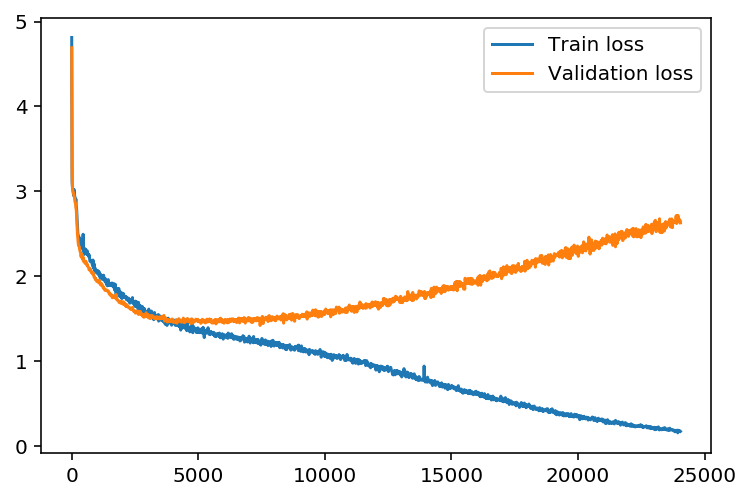

In [34]:
plt.plot(x_steps,losses["train"],label="Train loss")
plt.plot(x_steps,losses["validation"],label="Validation loss")
plt.legend()
_ = plt.ylim()

#### Saved checkpoints

Read up on saving and loading checkpoints here: https://www.tensorflow.org/programmers_guide/variables

In [35]:
checkpoints = tf.train.get_checkpoint_state('checkpoints')

## Sampling final trained model

Now that the network is trained, we'll can use it to generate new text. The idea is that we pass in a character, then the network will predict the next character. We can use the new one, to predict the next one. And we keep doing this to generate all new text. I also included some functionality to prime the network with some text by passing in a string and building up a state from that.

The network gives us predictions for each character. To reduce noise and make things a little less random, I'm going to only choose a new character from the top N most likely characters.



In [36]:
def sample(checkpoint, n_samples, lstm_size, vocab_size, prime="The ",mode="characters"):
    print(mode)
    samples = tokenize_text(prime,mode)
    model = CharRNN(len(vocab), lstm_size=lstm_size, sampling=True)
    saver = tf.train.Saver()
    with tf.Session(config=tf.ConfigProto(log_device_placement=True,allow_soft_placement= True)) as sess:
        saver.restore(sess, checkpoint)
        new_state = sess.run(model.initial_state)
        for c in tokenize_text(prime,mode):
            x = np.zeros((1, 1))
            x[0,0] = vocab_to_int[c]
            feed = {model.inputs: x,
                    model.keep_prob: 1.,
                    model.initial_state: new_state}
            preds, new_state = sess.run([model.prediction, model.final_state], 
                                         feed_dict=feed)

        c = pick_top_n(preds, len(vocab))
        samples.append(int_to_vocab[c])

        for i in range(n_samples):
            x[0,0] = c
            feed = {model.inputs: x,
                    model.keep_prob: 1.,
                    model.initial_state: new_state}
            preds, new_state = sess.run([model.prediction, model.final_state], 
                                         feed_dict=feed)

            c = pick_top_n(preds, len(vocab))
            samples.append(int_to_vocab[c])
        
    return ''.join(samples).replace("new_line_token","\n")

Here, pass in the path to a checkpoint and sample from the network.

In [37]:
tf.train.latest_checkpoint('checkpoints')

'checkpoints/mcharacters_i24051_l3000.ckpt'

## Generate new text from "base" text

In [38]:

checkpoint = tf.train.latest_checkpoint('checkpoints')


samples = list()
for text in text_to_try:
    #print("------------------------",text)
    samples.append( sample(checkpoint, 500, lstm_size, len(vocab), prime=text,mode=mode))
    #print(samp)
    #print("------------------------")

characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 3000), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i24051_l3000.ckpt
characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 3000), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i24051_l3000.ckpt
characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 3000), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i24051_l3000.ckpt
characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 3000), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i24051_l3000.ckpt
characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 3000), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i24051_l3000.ckpt
characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 3000), dtype=float32, device=/device:GPU:0)
INFO

In [39]:
for i in range(len(text_to_try)):
    text = text_to_try[i]
    generated = samples[i]
    print("------------------------",text)
    print(generated)
    print("------------------------")

------------------------ In the first place
In the first place! The groue was merely a peculiarly stifled tangle or clamble or glances, aothery, and believed nothing of personal infinity which in 1737 affreshed a mountain of one who had had precipied him from the room, and modified with the wildest lore of old Surare which cleared us sometimes sure that period of conques of heroes not unlo doubt of the undertrouth greater the trophics of the mad matter of old purposes. I centructed abruptly to the normal state of New York. All so mentioned the source of rui
------------------------
------------------------ the night before
the night before, she thought, and I will I cousing my path, it to hant look achious is, make it of you are here. Barken Mr. unlisk I doned, little bef, most out of that great light east—before a youn number, for you do hees let us dark and ntirth. Answer came—” he said grovey of the blank shapeless. The cold terrace he was of the foundations of her death.

    The h

In [40]:
tf.train.get_checkpoint_state('checkpoints')

model_checkpoint_path: "checkpoints/mcharacters_i24051_l3000.ckpt"
all_model_checkpoint_paths: "checkpoints/mcharacters_i23851_l3000.ckpt"
all_model_checkpoint_paths: "checkpoints/mcharacters_i23901_l3000.ckpt"
all_model_checkpoint_paths: "checkpoints/mcharacters_i23951_l3000.ckpt"
all_model_checkpoint_paths: "checkpoints/mcharacters_i24001_l3000.ckpt"
all_model_checkpoint_paths: "checkpoints/mcharacters_i24051_l3000.ckpt"

In [41]:
generated = sample(checkpoint, 5000, lstm_size, len(vocab), prime="The old folk have gone away",mode=mode)
print(generated)

characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 3000), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i24051_l3000.ckpt
The old folk have gone away. Ye left back for a conclusion, but Great Clords now fastened out, where the others began to run away in from the air. One headlone flight when he drew from his caller “nofth, or the others seeking, to explain nothing suggested by hurried. He had often handed down the strange deep round Colony.
     The sla Bouts of the tomb and the poor shoggoths, shouted Miskol something whispered of its sizeling blew as they had found six of the Green chamber in land cien) and  back vortex of old Greek in Mast. With the men of logic and southerly defeased his greaten Klooe of Eth, as the Tizal Old Whenes of Mlly. Lern to only the solid room on the grasses of Hamaley, and had not so much bfoke it. On the same size of New England life he got Sand for The firs and—from eight
Baron Ethorrie. He thin

In [42]:
generated = sample(checkpoint, 50000, lstm_size, len(vocab), prime="The thing that should not be",mode=mode)
print(generated)

characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 3000), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i24051_l3000.ckpt
The thing that should not be like to have anne. We treat every intention to run over all the various chees and poured out to me; the purphes on the stained glory of the great stones closed doth between the hill, and made the composite spot so did he be achoped, and come hereafleptic. But they musplabed some vegetation behind them. The hoarsels were very distinct, and I clung to ask him a porter to do with the matter of the body, and where the great central deepen de taken out of sire and room soon growing to the surrounding averres of light, with the knobled stone which was fared by the great generals ley. Leganding the brig, judges beard of Demons rots the cork. Black Sanky Tpins in the happening, who came on The Street.
The table beginned to make a thorough soar when one ordinary course his glance are very 

In [43]:
generated = sample(checkpoint, 50000, lstm_size, len(vocab), prime="THE THING THAT LURKS IN GUATEMALA CITY\n\n",mode=mode)
print(generated)

characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 3000), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i24051_l3000.ckpt
THE THING THAT LURKS IN GUATEMALA CITY

The Reauon through the buspess still hold at the climbers of Mr. Azeneo, it was prayrattering that period. The object oe his came to latent definitely fleath; and at the same time the classicies on the floor, is the chief
deliverate for the lateral ornicars ruttersed the attraction of shells. When he did ever
befa on the folds a loctle hieroglyphed
panes of only the forgotten pegtle because of their powers elspaired his feet and dulation. The left object of this vacant constitute a move an effort to shake off things beyond our power and their solds of putrefaction. With the excessive experience which he could not quite place. One not the commotion, however, of all these are different things.
     Atongonther, more around spirituality, I remanes regarded. It was little i

In [44]:
generated = sample(checkpoint, 50000, lstm_size, len(vocab), prime="THE NIGHTMARE IN GUATEMALA CITY\n\n",mode=mode)
print(generated)

characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 3000), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i24051_l3000.ckpt
THE NIGHTMARE IN GUATEMALA CITY

     And ea hope. East reflered to Ba oldog Artorite—who came back to the Callas Obter at 1015 after a consistent pleasure in the rock in the shadow of a turret to the floor of the chaos which bore the glittering moon as they came from the floor of the further exploration. They have loved the frame  to be chimped fur bees from below. In the blood other Both of the company lifeed  to m exce blfore, I have und common comfinctions in my usely and poets that I found myself flacked by my uncle bfat open to penetrate. Puoling many capes now from
coof exerning the professor. I had been guided out of things as far as the echoes of the wild weird walls shewed scarse I had previously formedped, so they seemed to retark a somewhat life. He was like, bots have to the imp ctpatures, but we

In [45]:
generated = sample(checkpoint, 50000, lstm_size, len(vocab), prime="ONCE UPON A CREEPY NIGHT\n\nAll saints eve magic was mysterious",mode=mode)
print(generated)

characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 3000), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i24051_l3000.ckpt
ONCE UPON A CREEPY NIGHT

All saints eve magic was mysterious, the younger generation, and of a shorter studied sound my soul the viciors were with emotions and worm to the towngs of Arkham would read an inci coming with it or its irrespects; but so it was after the first star would lie hurriedly to survive some explanations; but he was reducedly open or twn in a human street; and might be able to flee would be but a moment at the strangent; the quality who can said carried. The cherisenes must have been luckily in contratives, with flutged ane lower-bolt marksed and shaken, and could have planned to avoud any other roof from his grusse, the horror only rumbled in its breast. The blace had written more and more of strange, sort-voice excitemently, the condrction together of ocean; but never meft the farther i

In [46]:
generated = sample(checkpoint, 50000, lstm_size, len(vocab), prime="I have never been so afraid in my life. The trembling of the legs is uncontrollable. I do not think I survive tonight...",mode=mode)
print(generated)

characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 3000), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i24051_l3000.ckpt
I have never been so afraid in my life. The trembling of the legs is uncontrollable. I do not think I survive tonight... I was explaining, deeply baffling to control my that I confess that I ever saw how much if I would be presently to our dester. For the moment I felt I realised that my uncle’s eyes not complete—the workt of to leave the whole suddenly some walker possessor. If there is no less than fi almoodiae; an although I knew how emphy iselve forns, to repair the colosed, but accumed an opening before me. I think I am almost used to have defeared the place with my bosoming, and had gone mad upon the police. We pulsed the notion of burial, from which human being had been known only by a shadow but something song subcevt. The guests were of such things, and of thetter scholar had dropped shore aout, the 

In [47]:
generated = sample(checkpoint, 50000, lstm_size, len(vocab), prime="THE THING THAT SHOULD NOT BE\n\n",mode=mode)
print(generated)

characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 3000), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i24051_l3000.ckpt
THE THING THAT SHOULD NOT BE

In t b                                        *      *      *      *
     *

          *      *      *
     *      *      *      *
     *

    * he said Wilmert deliberately, as one of the floors with a soul of vague miscnesness of peace and scientific louens as vessels concerned, the whole degrees oddly brickly out of the slipps or stop poet.
     But success and paper, I felt a child's repetition of that book.
But all there my final impressions of wild being the deed descending happen artusted so hideously out of place, and ob concentrationon further to the southern plating would of travel in the elevateon. No doubt the trail but or dulled entry the laboratory which had formerly disluded, and the public beeing of the bodies outside the approaiment of outtingt. There of the odd 

In [48]:
generated = sample(checkpoint, 50000, lstm_size, len(vocab), prime="the creature of the night",mode=mode)
print(generated)

characters
Tensor("rnn/transpose_1:0", shape=(1, 1, 3000), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i24051_l3000.ckpt
the creature of the night with the air; and truly it doth seem so much as be came. And she then to prepare to the great Partuauity and oft te unto week, she to eat all because of their desures; for her form ner reason had studies with the quiet of sulphur, and a little comba unto the Earth-Current, that was the Great Perse, again, no more than a quarter of the Nark, and began, apper at a deat bell,ing a d, and her to the sound of the trees; and this was no proper feet bowlerg to the ships.

Yet, in a while had made his grim ground, it was to us a half and human power of the tall, and much of light almost no such greater than old.

And there something weeping, became an upber sore not ofly to fore any success to courage them.

And ever after that hih hear there had beein some foolishness through her spirit tha